In [1]:
from IPython.display import display, HTML

display(HTML(data="""

<style>
    div#notebook-container    { width: 90%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

%reload_ext jupyternotify

#%notify

<IPython.core.display.Javascript object>

In [2]:
import sys

import numpy as np
import qutip as qtp
import matplotlib.pyplot as plt

import time
import datetime
import os

from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib notebook
plt.rcParams['figure.figsize'] = (10, 7)

In [3]:
# import pysqkit.tomography.utilsTomo as tomo
import pysqkit

<IPython.core.display.Javascript object>

It took  1.234875202178955 seconds
0j
0j


# Description of Tomography Process

## $\{ \rho_i \}$

We take the following convention : 
$$\text{The } \left\{ \rho_i \right\} \text{ are the } \left|n\right>\left<m\right| \text{ ; } n,m \in [\![0, \text{d} ]\!]^2 $$
$$ \text{For 2 systems : the } \left\{ \left|n\right> \right\} \text{are the} \left|ab\right> \text{ ; } a,b \in [\![0, \textit{nb_levels}[0] ]\!] \times [\![0, \textit{nb_levels}[1] ]\!] $$

 
R) d is the total number of levels : $d = \prod _{i} \textit{nb_levels}[i]$ 
In the case of quBits, $d = 2^n$ with $n$ being the number of qubits in the system.  \
For quDits having k levels, it is $d = k^n$



R) There are $d^2$ terms in the $\left\{\rho_i\right\}$ family and each of them has $d^2$ components

## $\{ \tilde{E_i} \}$

We take the following convention : \
$\{\tilde{E_i} \}$ is the basis for operators. There are $d^2$ of them and each has $d^2$ components.

Usually when there are 2 levels, we take Pauli matrices and tensor product of pauli matrices. \
For higher levels we will use Generalized Gell-Mann matrices.

If $P_j ; (j=1...d)$ is the basis for a L levels qudit then ($d=L^2$) : 
$$\forall i \in [\![1, d^2 ]\!] , \exists! j,k \in [\![1, d]\!]^2 \text{ so that } \tilde{E_i} = P_j\otimes P_k$$


## $\textit{fct_to_lambda(...)}$

$$\lambda \in d^2 \times d^2 \text{ is the matrix defined by : } \mathcal{E} (\rho_j) = \sum_k \lambda_{jk} \rho_k \text{    ($\mathcal{E}$ is the gate)}$$

## $\textit{lambda_to_chi(...)}$

The $\chi$ matrix for a basis $\left\{ \tilde{E_i} \right\}$ of operators is defined by the following formula :

$$\mathcal{E}(\rho) = \sum_{mn} \chi_{mn} \tilde{E_m}\rho\tilde{E_n}^\dagger$$

Some examples of $\chi$ matrices :

For 1 qubits : X operator $$\chi_X = \begin{bmatrix}
0 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0
\end{bmatrix}$$

For 2 qubits : $U_{CNOT} = I\otimes I + I\otimes X + Z\otimes I - Z\otimes Z$ donc : 
$$\chi_{CNOT} = \begin{bmatrix}
 1 &  1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  1 & -1 & 0 & 0 \\
 1 &  1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  1 & -1 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 1 &  1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  1 & -1 & 0 & 0 \\
-1 & -1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 &  1 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0
\end{bmatrix}$$

## $\textit{lambda} \leftrightarrow \textit{chi}$  through  $ \beta$

The $\beta$ matix is defined as follows :  
$$\tilde{E_m} \rho_j \tilde{E_n}^{\dagger} = \sum_k \beta_{jk}^{mn}  \rho_k $$
$$ m,n \in \left[\!\left[1,d^2\right]\!\right]^2 \text{  and  } j,k \in \left[\!\left[1,d^2\right]\!\right]^2$$

So if follows : 
$$\beta_{jk}^{mn} = Tr \left\{ \tilde{E_m} \rho_j \tilde{E_n}^{\dagger} \rho_k^{\dagger} \right\} $$

We choose to index $\beta$ as a matrix with rows labeled $(j,k)=\mu$ and columns labeled $(m,n) = \nu$. \
$\beta \in d^4 \times d^4$

We test 8.158 to check if the $\chi$ matrix coincides qith the caculated $\beta$ and $\lambda$:

With our convention of $\mu = (j,k)$ ans $\nu = (m,n)$ , this equation is : 
$$\sum_{\nu} \beta_{\mu}^{\nu} \chi_{\nu} = \lambda_{\mu} \ ; \ \forall \mu \in [\![ 1, d^4]\!]$$

R) The left side of this equation is labelled $\textit{lambda_th_mat}$ or $\lambda_{ij}^{th}$

## $\textit{chi_to_kraus(...)}$

We use the formula 8.168 from Nielsen and Chuang : 

$$ E_i = \sqrt{d_i}\sum_j U_{ij} \tilde{E_j}$$ 

$$ \text{  with  } U \text{  such that  } \chi = UDU^\dagger \text{ ; } U \text{ unitary and } D \text{ diagonal }$$

## Fidelities $L_1$ ; $L_2$ ; $\overline{F}$

In the equations below, $\mathcal{E}$ and $\tilde{\lambda}$ are defined as follows : 

$$ \mathcal{G} = \mathcal{G}^{\text{ideal}} \circ \mathcal{E} $$


$\lambda$ is the matrix representation of $\mathcal{G}$ in the density matrix basis. And $\tilde{\lambda}$ is the matrix representation of $\mathcal{E} in tha same basis. We obtain its value by the following formula : 

$$\tilde{\lambda} = \lambda_{\text{ideal}^{-1}} \cdot \lambda$$

We have $\lambda_{\text{ideal}^{-1}}$ = $\lambda_{\text{ideal}}^{-1}$ the representation of the ideal gate. (The $\lambda_{\text{ideal}^{-1}}$ should be easier to calculate, as the representation of the inverse of the ideal gate.)

We use the formula (2) from Wood Gambetta :  

For $L_1$ we have :


$$\begin{align} 
L_1 & = \langle \ L \left(  \ \mathcal{E} \left( | \psi_1 \rangle \langle \psi_1 | \right)  \  \right) \ \ \rangle \text{  Average taken for $\psi_1 \in \chi_1$}  \\
& = \dfrac{1}{d_1} \sum_{i \in Ind \chi_1} L \left(  \ \mathcal{E} \left( | \psi_i \rangle \langle \psi_i | \right)  \  \right) \text{  With $| \psi_i \rangle$ a base of $\chi_1$} \\ 
& = \dfrac{1}{d_1} \sum_{i \in Ind \chi_1} Tr  \left( \mathbb{1}_2 \ \mathcal{E} \left( | \psi_i \rangle \langle \psi_i | \right)  \  \right) \\
& = \dfrac{1}{d_1} \sum_{i \in Ind \chi_1} \sum_{j \in Ind \chi_2} Tr  \left( \mathcal{E} \left( | \psi_i \rangle \langle \psi_i | \right)^\dagger \cdot \ | \psi_j \rangle \langle \psi_j | \  \right) \text{  With $| \psi_j \rangle$ a base of $\chi_2$} \\ 
& = \dfrac{1}{d_1} \sum_{i \in Ind \chi_1} \sum_{j \in Ind \chi_2}  \tilde{\lambda}_{(i+i\times d), (j+j\times d)}  \quad \text{  ($i+i\times d$) is the index of $| \psi_i \rangle \langle \psi_i |$ in the base of $\{ \rho_j \}$}
\end{align}$$


Similarly for $L_2$ we have :

$$ L_2 = 1 - \dfrac{1}{d_2} \sum_{i \in Ind \chi_2} \sum_{j \in Ind \chi_2}  \tilde{\lambda}_{(i+i\times d), (j+j\times d)} $$

Now : 
$$\overline{F} = 
$$

# Tutorial

## Defining an environment

In [4]:
#From a U matrix :

# #Set U
# U_CNOT = np.zeros((4,4))
# U_CNOT[0,0] = 1
# U_CNOT[1,1] = 1
# U_CNOT[2,3] = 1
# U_CNOT[3,2] = 1
# U_CNOT = qtp.Qobj(U_CNOT, dims = [[2,2], [2, 2]])


# U_0 = qtp.Qobj(np.zeros((4,4)), dims = [[2,2], [2,2]])

# sigmai = qtp.sigmax()
# sigmaj = qtp.sigmaz()
# U_i_j = qtp.tensor(sigmai, sigmaj)

# nb_levels = [2, 2]

# U_rand = qtp.Qobj(2*(np.random.rand(nb_levels[0]*nb_levels[1], nb_levels[0]*nb_levels[1])-.5) + \
#                   2j*(np.random.rand(nb_levels[0]*nb_levels[1], nb_levels[0]*nb_levels[1])-.5), 
#                    dims = [nb_levels, nb_levels]).unit() #qtp.qeye([2]*mult)


nb_levels = [3, 4]
d = np.prod(nb_levels)
U_id = qtp.qeye(nb_levels)
#Use the build in constructor
U_id_err = U_id + qtp.Qobj(np.random.random((d,d))*.1 , dims = U_id.dims)#add in some error
param_test = { 'U' : U_id_err}

env_U = pysqkit.tomography.TomoEnv(nb_levels, 'U', param_test, table_states = None)

In [5]:
#From a set of Kraus operators :

#Set list of operators

# nb_levels = [2,2] #[2,2]
# d = np.prod(nb_levels)

# op_list_id = [qtp.qeye(nb_levels)]

# op_list_random = [qtp.Qobj(2*(np.random.rand(d, d)-.5) + 2j*(np.random.rand(d, d)-.5), 
#                    dims = [nb_levels, nb_levels]) for i in range(d**2)]

# op_list_xyz = [qtp.tensor(qtp.qeye(2), qtp.sigmax()), 
#                qtp.tensor(qtp.qeye(2), qtp.sigmay()),
#                qtp.tensor(qtp.qeye(2), qtp.sigmaz())]

# #Use the build in constructor
# op_list = op_list_id

# param_test = { 'op_list' : op_list}

# env_kraus = pysqkit.tomography.TomoEnv(nb_levels, 'kraus', param_test, table_states = None)

In [6]:
#From a simulation based process : 

# nb_levels =  
# param_test_simu = {
    
# }

# env = pysqkit.tomography.TomoEnv(nb_levels, 'simu', param_test_simu, table_states = eigstates_sys)


## Tomography

<IPython.core.display.Javascript object>


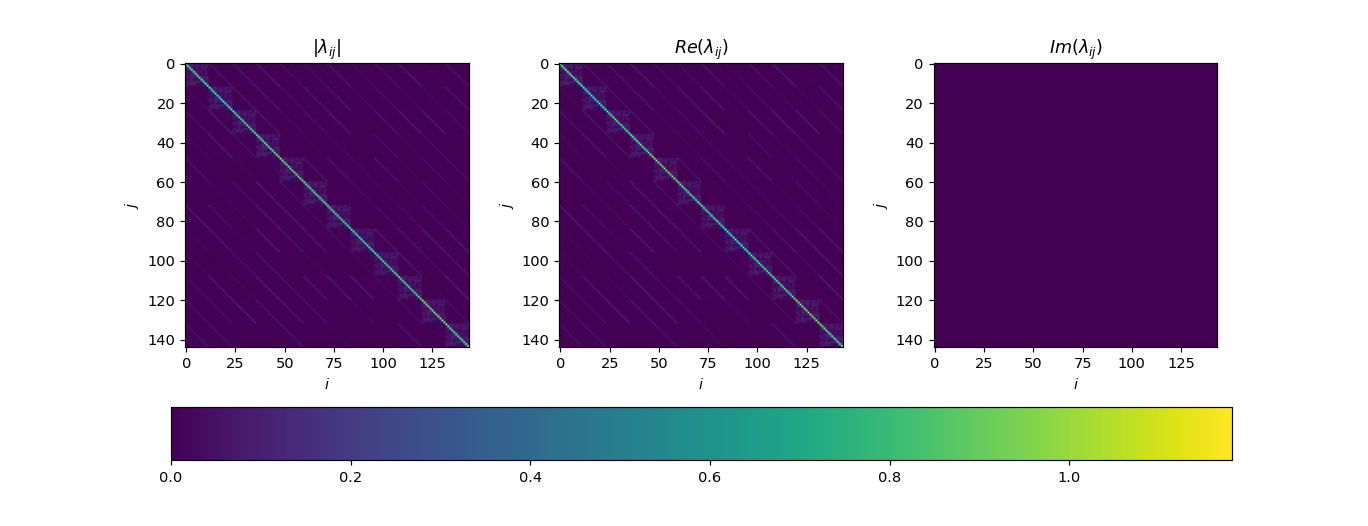

It took 15.126081705093384 seconds


In [13]:
deb =  time.time()
lambda_mat = env_U.fct_to_lambda(draw_lambda = True, as_qobj = False)
print("It took" , time.time() - deb, "seconds")

<IPython.core.display.Javascript object>


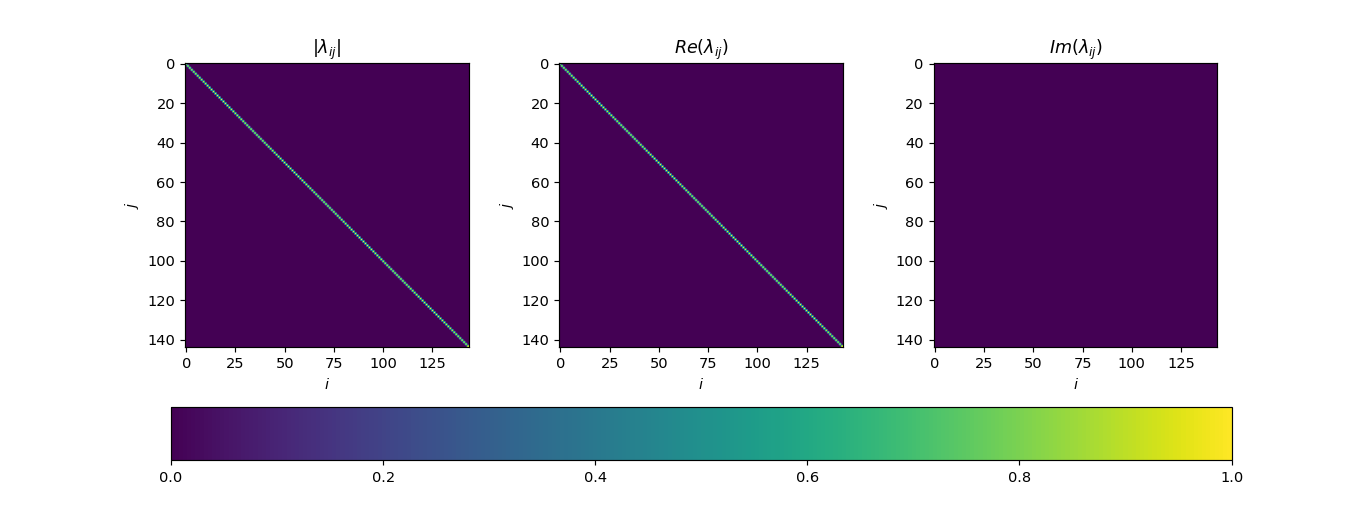

In [15]:
#we create the inv_lambda_ideal
#Use the build in constructor
U_ideal_inv = qtp.Qobj(np.linalg.inv(U_id.full()), dims = U_id.dims)
param_test_ideal = { 'U' : U_ideal_inv}
env_ideal = pysqkit.tomography.TomoEnv(nb_levels, 'U', param_test_ideal, table_states = None)

inv_ideal_lambda = env_ideal.fct_to_lambda(draw_lambda = True, as_qobj = False)

In [16]:
print("L1 error is ; ", env_U.L1(lambda_mat, inv_ideal_lambda))
print("L2 error is ; ", env_U.L2(lambda_mat, inv_ideal_lambda))

L1 error is ;  (0.024461216078001936+0j)
L2 error is ;  (-0.0879390935645461+0j)


In [11]:
deb =  time.time()
PTM_mat = env_U.fct_to_PTM(draw_PTM = True, as_qobj = False)
print("It took" , time.time() - deb, "seconds")

<IPython.core.display.Javascript object>

It took 0.9714531898498535 seconds


In [12]:
deb =  time.time()
chi_mat = env_U.lambda_to_chi(lambda_mat, draw_chi = True, as_qobj = False)
print("It took" , time.time() - deb, "seconds")

MemoryError: Unable to allocate 324. KiB for an array with shape (144, 144) and data type complex128

In [ ]:
deb = time.time()
kraus_list = env_U.chi_to_kraus(chi_mat, draw_kraus = True, as_qobj = False)
print("It took" , time.time() - deb, "seconds")

In [ ]:
deb = time.time()
PTM_mat_from_chi = env_U.chi_to_PTM(chi_mat, draw_PTM = True, as_qobj = True)
print("It took" , time.time() - deb, "seconds")

In [ ]:
#tests using beta, very costly in complexity
deb = time.time()
lambda_mat_from_beta = env_U.chi_to_lambda_beta(chi_mat, draw_lambda = True)
print("It took" , time.time() - deb, "seconds")

deb = time.time()
chi_mat_from_beta = env_U.lambda_to_chi_beta(lambda_mat, draw_chi = True)
print("It took" , time.time() - deb, "seconds")